In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import root_scalar
# import vegas
# import pandas as pd

# constants
M_sun = 1.9891e30 # solar mass in kg
yr2s = 31556926 # year in seconds
G = 6.67430e-11 # Newton gravity constant, m^3/kg/s^2
mp = 1.6726e-27 # proton mass, kg
kB = 1.38064e-23 # Boltzman constant, m^2 kg /s^2 /K
K2MeV = 1000 / 1.161e13 # Kelvin to MeV
K2erg = 1.3806e-16 # Kelvin to erg
MeV2kg = 1.783e-30 # MeV to kg
light_speed = 29979245800 # cm/s
M_sun_erg = 1.79e54 # solar mass to erg
g2erg = 8.987e20 # 1 gram to erg

# Preparing python dicts for different SN profiles
path_dict = {'LS220':'LS220-s18.88/','TF':'TF-10.8/','SFHo':'SFHo-18.8/'}
eps_dict = {'1e-11':1e-11,'1e-13':1e-13}

# LS220-s18.88
time_LS220 = np.array([0.025025958, 0.049998391, 0.074824948, 0.099864677, 0.12498343,0.1500311, 0.17509553, 0.20019816, 0.2248337, 0.24981552, 0.2748468,0.29991753, 0.32495867, 0.35001769, 0.37515225, 0.40005328,0.42519939, 0.44975758, 0.47488252, 0.50006312, 0.75020978,0.99981123, 1.2499211, 1.4998553, 1.7498401, 2.0001881, 2.2500268,2.5001422, 2.7499499, 3.0002358, 3.4997695, 4.0000049, 4.4997671,5.0000058, 5.5001784, 6.0000124, 7.0000407, 8.0001427, 8.9999821,9.9998723, 11.000235])
# TF-10.8
time_TF = np.array([0.0, 0.0005071633749998972, 0.001344984198914295, 0.002747482114197092, 0.005360368439765006, 0.009114730681676703, 0.01546656236520411, 0.02377903315351249, 0.0371038998588703, 0.07270743901011611, 0.1559318935712961, 0.1984338428379552, 0.2355246646583827, 0.2696407132612904, 0.2987081452406821, 0.3220030873362578, 0.3494485917853219, 0.4321251343862368, 0.6345777798749864, 0.8290217158061605, 1.148255042476532, 1.530587216869893, 1.850095515413669, 2.025641464550373, 2.291022256907176, 2.494024409449831, 2.776469255304346, 3.069363525669363, 3.181757573705697, 3.38167350130409, 3.589134145372821, 3.911817883753428, 4.300552294421064, 4.685719134837941, 4.982012461146646, 5.268128531663336, 5.64828123539431, 6.108655871270188, 6.606821133770339, 7.106768633770505, 7.606768633770672, 7.636883658096388, 7.646664932038442, 7.660086480352283, 7.666737588615097, 7.690023524550349, 7.82354227734557, 7.828542277345381, 7.833542277345192, 7.838542277345002, 7.844106817969775, 7.849128187336813, 7.854128187336624, 7.859216708957359, 8.070953649197923, 8.527035413357245, 9.013405594743654, 9.50413538884011, 10.00263288883984, 10.49505799144959]) 
# SFHo-18.8
time_SFHo = np.array([0.025059213, 0.05011927, 0.074826743, 0.09983578, 0.12485604, 0.14986846, 0.17488231, 0.19989878, 0.22491674, 0.24993268, 0.25008736, 0.2749493, 0.30021245, 0.32521253, 0.35011666, 0.37512281, 0.40013599, 0.42514829, 0.45015242, 0.47516306, 0.5001775, 0.74987351, 1.0002234, 1.2500327, 1.4997635, 1.749857, 2.0001179, 2.2501048, 2.5002329, 2.7502406, 3.0001038, 3.4998576, 4.0000753, 4.4999348, 5.0000931, 5.5000477, 5.9999425, 6.9999881, 8.0001694, 8.9998587, 10.000057])
time_dict = {'LS220':time_LS220,
             'TF':time_TF,
             'SFHo':time_SFHo}

number_of_r = 41
number_of_mAp = 91

In [3]:
# Load CSM data
# In the following we use realistic CSM density from Zimmerman+ Nature 627, 762 (2024)
rho_SN2020tlf_data = np.log10(np.loadtxt('CSM_density/SN2020tlf.txt').T)
rho_SN2023ixf_data = np.log10(np.loadtxt('CSM_density/SN2023ixf.txt').T)
rho_SN2024ggi_data = np.log10(np.loadtxt('CSM_density/SN2024ggi.txt').T)
# Interp in log10 scale
rho_2020tlf_interp = interp1d(rho_SN2020tlf_data[0],rho_SN2020tlf_data[1],kind='linear',bounds_error=False,fill_value=np.nan)
rho_2023ixf_interp = interp1d(rho_SN2023ixf_data[0],rho_SN2023ixf_data[1],kind='linear',bounds_error=False,fill_value=np.nan)
rho_2024ggi_interp = interp1d(rho_SN2024ggi_data[0],rho_SN2024ggi_data[1],kind='linear',bounds_error=False,fill_value=np.nan)

# r_max = rho_data[0][-1]
# r_min = rho_data[0][0]

r_mins = {'SN 2020tlf':10**rho_SN2020tlf_data[0,0],'SN 2023ixf':10**rho_SN2023ixf_data[0,0],'SN 2024ggi':10**rho_SN2024ggi_data[0,0]} 

def CSM_density(r,SN_name='SN 2023ixf'):
    """
    g/cm^3
    """
    r = np.log10(r)
    if SN_name == 'SN 2020tlf':
        return 10**rho_2020tlf_interp(r)
    elif SN_name == 'SN 2023ixf':
        return 10**rho_2023ixf_interp(r)
    elif SN_name == 'SN 2024ggi':
        return 10**rho_2024ggi_interp(r)
    else:
        raise ValueError('\'SN_name\' must be a \'SN 2020tlf\', \'SN 2023ixf\' or \'SN 2024ggi\'.')

SN_names = ['SN 2020tlf','SN 2023ixf','SN 2024ggi']

In [182]:
# load stopping power data
stop_power_e_H_data = np.loadtxt('stopping_power/electron_H.txt',skiprows=8).T
stop_power_e_He_data = np.loadtxt('stopping_power/electron_He.txt',skiprows=8).T
# interpolate, in log-scale
stop_power_e_H = interp1d(np.log10(stop_power_e_H_data[0]),np.log10(stop_power_e_H_data[-1]))
stop_power_e_He = interp1d(np.log10(stop_power_e_He_data[0]),np.log10(stop_power_e_He_data[-1]))

def e_stopping_power(Ek,target='H'):
    """
    Stopping power for electron in different target

    Parameters
    ----------
    Ek : scalar
        Electron kinetic energy, MeV (valid from 0.01 MeV to 1000 MeV)
    target : str
        Target that the electron is interacting with, 'H' or 'He'

    Returns
    -------
    out : scalar
        Electron stopping power, MeV cm^2/g
    """
    logEk = np.log10(Ek)
    if target == 'H':
        sp = 10**(stop_power_e_H(logEk))
    elif target == 'He':
        sp = 10**(stop_power_e_He(logEk))
    else:
        raise ValueError('\'target\' must be either \'H\' or \'He\'.')
    return sp

def e_stopping_length(Ek,r,target='H',SN_name='SN 2023ixf'):
    """
    Electron stopping length in CSM for different SNe

    Parameters
    ----------
    Ek : scalar
        Initial electron energy, MeV
    r : scalar
        CSM radii, cm
    target : str
        Target that the electron is interacting with, 'H' or 'He'
    SN_name : str
        Name of supernova, SN 2020tlf, SN 2023ixf or SN 2024ggi

    Returns
    -------
    out : tup
        Stopping length (cm)
    """
    rho = CSM_density(r,SN_name)
    S = e_stopping_power(Ek,target) # stopping power, MeV cm^2/g
    stop_length = Ek / S / rho # travel distance for electron to deposit all its kinetic energy to the ambient target
    #stop_time = stop_length / light_speed
    return stop_length #,stop_time

Text(0, 0.5, '$\\rho$ [g cm$^{-3}$]')

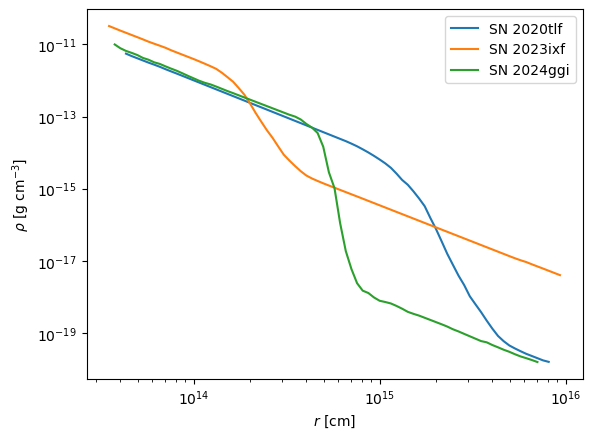

In [510]:
CSM_radii = np.logspace(13,16,100)
for SN_name in SN_names:
    CSM_rho = CSM_density(CSM_radii,SN_name=SN_name)
    plt.plot(CSM_radii,CSM_rho,label=SN_name)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$\rho$ [g cm$^{-3}$]')
#plt.savefig('CSM_rho.pdf',bbox_inches='tight')

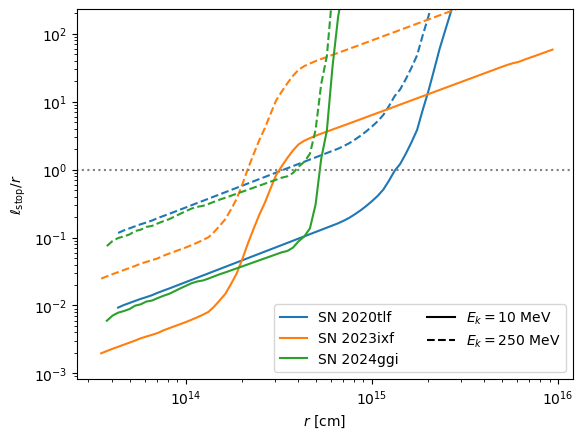

In [402]:
colors = ['C0','C1','C2','C3','C4']
i = 0
for SN_name in SN_names:
    esl_Ek10 = e_stopping_length(10,CSM_radii,SN_name=SN_name)
    esl_Ek250 = e_stopping_length(250,CSM_radii,SN_name=SN_name)
    plt.plot(CSM_radii,esl_Ek10/CSM_radii,color=colors[i],label=SN_name)
    plt.plot(CSM_radii,esl_Ek250/CSM_radii,'--',color=colors[i])
    i+=1
plt.plot([3e12,1e17],[1,1],':',color='gray')
plt.plot([1e14,1e15],[1e-9,1e-9],'k',label=r'$E_k=10$ MeV')
plt.plot([1e14,1e15],[1e-9,1e-9],'--k',label=r'$E_k=250$ MeV')
plt.xscale('log')
plt.yscale('log')
plt.xlim(2.6e13,1.2e16)
plt.ylim(8.3e-4,2.3e2)
plt.legend(ncol=2)
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$\ell_{\rm stop}/r$')
plt.savefig('stopping_length.pdf',bbox_inches='tight')

In [174]:
def get_r_equal_esl(Ek,target='H',SN_name='SN 2023ixf'):
    """
    Get the CSM radius that equals electron stopping length at Ek

    Parameters
    ----------
    Ek : scalar
        Initial electron energy, MeV
    target : str
        Target that the electron is interacting with, 'H' or 'He'
    SN_name : str
        Name of supernova, SN 2020tlf, SN 2023ixf or SN 2024ggi

    Returns
    -------
    out : scalar
        CSM radius = electron stopping length, cm
    """
    _ratio = lambda r: e_stopping_length(Ek,r,target,SN_name) - r
    sol = root_scalar(_ratio,bracket=[5e13,7e15],x0 = 3e14,xtol=1e-10,rtol=1e-10)
    return sol.root

In [164]:
mAp_masses = np.logspace(0,3,100)
r_equal_SN2020tlf = []
r_equal_SN2023ixf = []
r_equal_SN2024ggi = []
for mAp in mAp_masses:
    if mAp <= 50: mAp = 50 # take minimum Ek as the maximum core temperature
    Ek = mAp/2
    r_equal_SN2020tlf.append(get_r_equal_esl(Ek,SN_name='SN 2020tlf'))
    r_equal_SN2023ixf.append(get_r_equal_esl(Ek,SN_name='SN 2023ixf'))
    r_equal_SN2024ggi.append(get_r_equal_esl(Ek,SN_name='SN 2024ggi'))

# interpolationg
r_equal_SN2020tlf_interp = interp1d(np.log10(mAp_masses),np.log10(r_equal_SN2020tlf),kind='linear',bounds_error=False,fill_value=np.nan)
r_equal_SN2023ixf_interp = interp1d(np.log10(mAp_masses),np.log10(r_equal_SN2023ixf),kind='linear',bounds_error=False,fill_value=np.nan)
r_equal_SN2024ggi_interp = interp1d(np.log10(mAp_masses),np.log10(r_equal_SN2024ggi),kind='linear',bounds_error=False,fill_value=np.nan)

# Define function to retriev r that corresponds to r = e stopping length
def r_equal_esl(mAp,SN_name='SN 2023ixf'):
    """
    cm
    """
    mAp = np.log10(mAp)
    if SN_name == 'SN 2020tlf':
        return 10**r_equal_SN2020tlf_interp(mAp)
    elif SN_name == 'SN 2023ixf':
        return 10**r_equal_SN2023ixf_interp(mAp)
    elif SN_name == 'SN 2024ggi':
        return 10**r_equal_SN2024ggi_interp(mAp)
    else:
        raise ValueError('\'SN_name\' must be a \'SN 2020tlf\', \'SN 2023ixf\' or \'SN 2024ggi\'.')

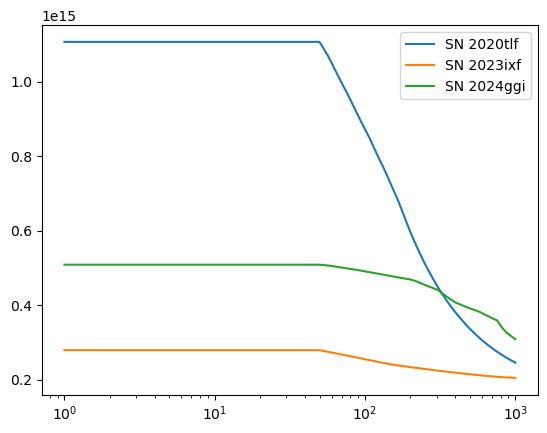

In [166]:
for SN_name in SN_names:
    plt.plot(mAp_masses,r_equal_esl(mAp_masses,SN_name),label=SN_name)
plt.xscale('log')
plt.legend()
#plt.yscale('log')

In [13]:
def fname(time,eps,SN_profile):
    fn_ret_dict = {'LS220':f'timeprofile_{time:d}_eps_{eps:.0e}_more.dat',
               'TF':f'timeprofile_{time:d}_eps_{eps:.0e}_more_TF.dat',
               'SFHo':f'timeprofile_{time:d}_eps_{eps:.0e}_SFHo_more.dat'}
    fn_adv_dict = {'LS220':f'timeprofile_{time + 1:d}_eps_{eps:.0e}_more.dat',
               'TF':f'timeprofile_{time + 1:d}_eps_{eps:.0e}_more_TF.dat',
               'SFHo':f'timeprofile_{time + 1:d}_eps_{eps:.0e}_SFHo_more.dat'}
    return fn_ret_dict[SN_profile],fn_adv_dict[SN_profile]

### Trapezoidal Rule
I use trapezoidal rule to do the time integration,
$$
\frac{dL}{dr} = \int_{t_{\rm min}}^{t_{\rm max}} dt~\frac{dL}{dt dr} = \frac{1}{2}\sum_{i=0}^{40} \left[\frac{dL}{dt dr}(t_{i+1})+\frac{dL}{dt dr}(t_i)\right] \Delta t
$$
where $\Delta t =t_{i+1}-t_{i}$.

In [60]:
# Specify SN profile & eps
SN_profile = 'TF' # 'LS220', 'TF', 'SFHo'
eps = '1e-11' # '1e-13'

# Specify file path, epsilon & time list
path = path_dict[SN_profile]
eps = eps_dict[eps]
time_list = time_dict[SN_profile]
number_of_time_steps = len(time_list)

dQ_int = np.zeros(number_of_r * number_of_mAp) # how many rows of dQ

for time in range(number_of_time_steps - 1):
    fn_ret,fn_adv = fname(time,eps,SN_profile) # file name

    data_retard = np.loadtxt(path + fn_ret)  # data at time_id
    data_advanced = np.loadtxt(path + fn_adv)  # data at (time_id + 1)
    
    # dL at time_id
    dQ_T_retard = data_retard[:,3]
    dQ_L_retard = data_retard[:,4]
    dQ_tot_retard = dQ_T_retard + dQ_L_retard # sum over polarizations
    
    # dL at (time_id + 1)
    dQ_T_advanced = data_advanced[:,3]
    dQ_L_advanced = data_advanced[:,4]
    dQ_tot_advanced = dQ_T_advanced + dQ_L_advanced # sum over polarizations
    
    # Delta t
    dt = time_list[time + 1] - time_list[time]
    
    # time integration at this Delta t
    dQ_int += (dQ_tot_advanced + dQ_tot_retard) * dt
dQ_int = dQ_int / 2 # trapezoid area

# Replace T, L polarizations different time steps with time-integrated value
data_time_int = np.hstack(((data_retard.T[:3]).T, dQ_int.reshape(-1,1)))
# Save data
np.savetxt(path + 'time_integrated/time_int_eps_' + str(eps) + '.txt',data_time_int,fmt='%.5e',header = 'mAp [MeV]  epsilon []  r [cm]  (dQ/drdt)*dt [erg/cm]')

### Energy deposition
To get the energy deposition $Q$ of DP, we integrate over $r$
$$
Q(\epsilon) =\int_{r_{\rm min}}^{r_{\rm max}}\frac{dQ}{dr}(\epsilon,r)
$$
where $dQ/dr$ for arbitrary $(\epsilon,r)$ can be scaled from a reference $dQ/dr$ derived at $\epsilon_0$,
$$
\frac{dQ}{dr}(\epsilon,r)=\left(\frac{\epsilon}{\epsilon_{0}}\right)^{4}\frac{dQ}{dr}(\epsilon_{0},(\epsilon/\epsilon_{0})^{2}r)
$$

In [680]:
# To run the following function, it requires time-integrated dQ is evaluated already

def energy_deposition(mAp_i,r,eps,SN_profile='LS220'):
    """
    In
    ---
    mAp_i : the i-th mAp mass, total 91 mAp masses are calculated, int
    r_min : minimum radius for energy depostion, cm 
    r_max : maximum radius for energy depostion, cm
    eps_list : a list of epsilon to be evaluated for energy deposition

    Out
    ---
    Q : total energy deposition, r
    """
    # Grid number of CSM radius in (1e12,1e20) cm in log-scale
    r_grids = 41
    # Load time-integrated data
    path = path_dict[SN_profile]
    data_eps_1e_minus_13 = np.loadtxt(path + 'time_integrated/time_int_eps_1e-13.txt')[r_grids * mAp_i : r_grids * (mAp_i + 1)] # eps = 1e-13
    data_eps_1e_minus_11 = np.loadtxt(path + 'time_integrated/time_int_eps_1e-11.txt')[r_grids * mAp_i : r_grids * (mAp_i + 1)] # eps = 1e-11
    
    # Data arrangement
    mAp_mass = data_eps_1e_minus_13[1,0]
    log_r = data_eps_1e_minus_13[:,2]
    dQ_time_int_1e_minus_13_log10 = np.log10(data_eps_1e_minus_13[:,3]) # log10(energy deposition) for eps = 1e-13
    dQ_time_int_1e_minus_11_log10 = np.log10(data_eps_1e_minus_11[:,3]) # log10(energy deposition) for eps = 1e-11
    # interpolation
    dQ_minus_13_log10 = interp1d(log_r,dQ_time_int_1e_minus_13_log10)
    dQ_minus_11_log10 = interp1d(log_r,dQ_time_int_1e_minus_11_log10)
    dQ_minus_13 = lambda r: 10**dQ_minus_13_log10(np.log10(r))
    dQ_minus_11 = lambda r: 10**dQ_minus_11_log10(np.log10(r))

    # dL for arbitrary eps and r
    def dQ(eps,r):
        try:
            # try reference eps = 1e-11 first
            scaling = (eps / 1e-11)**4
            r_p = (eps / 1e-11)**2 * r
            return scaling * dQ_minus_11(r_p)
        except:
            # try reference eps = 1e-13
            scaling = (eps / 1e-13)**4
            r_p = (eps / 1e-13)**2 * r
            return scaling * dQ_minus_13(r_p)

    return dQ(eps,r)

def total_energy_deposition(mAp_i,r_min,r_max,eps_list = [1e-11],SN_profile='LS220'):
    """
    In
    ---
    mAp_i : the i-th mAp mass, total 91 mAp masses are calculated, int
    r_min : minimum radius for energy depostion, cm 
    r_max : maximum radius for energy depostion, cm
    eps_list : a list of epsilon to be evaluated for energy deposition

    Out
    ---
    Q : total energy deposition, r
    """
    # Grid number of CSM radius in (1e12,1e20) cm in log-scale
    r_grids = 41
    # Load time-integrated data
    path = path_dict[SN_profile]
    data_eps_1e_minus_13 = np.loadtxt(path + 'time_integrated/time_int_eps_1e-13.txt')[r_grids * mAp_i : r_grids * (mAp_i + 1)] # eps = 1e-13
    data_eps_1e_minus_11 = np.loadtxt(path + 'time_integrated/time_int_eps_1e-11.txt')[r_grids * mAp_i : r_grids * (mAp_i + 1)] # eps = 1e-11
    
    # Data arrangement
    mAp_mass = data_eps_1e_minus_13[1,0]
    log_r = data_eps_1e_minus_13[:,2]
    dQ_time_int_1e_minus_13_log10 = np.log10(data_eps_1e_minus_13[:,3]) # log10(energy deposition) for eps = 1e-13
    dQ_time_int_1e_minus_11_log10 = np.log10(data_eps_1e_minus_11[:,3]) # log10(energy deposition) for eps = 1e-11
    # interpolation
    dQ_minus_13_log10 = interp1d(log_r,dQ_time_int_1e_minus_13_log10)
    dQ_minus_11_log10 = interp1d(log_r,dQ_time_int_1e_minus_11_log10)
    dQ_minus_13 = lambda r: 10**dQ_minus_13_log10(np.log10(r))
    dQ_minus_11 = lambda r: 10**dQ_minus_11_log10(np.log10(r))

    # dL for arbitrary eps and r
    def dQ(eps,r):
        try:
            # try reference eps = 1e-11 first
            scaling = (eps / 1e-11)**4
            r_p = (eps / 1e-11)**2 * r
            return scaling * dQ_minus_11(r_p)
        except:
            # try reference eps = 1e-13
            scaling = (eps / 1e-13)**4
            r_p = (eps / 1e-13)**2 * r
            return scaling * dQ_minus_13(r_p)

    energy_dep_list = []
    for eps in eps_list:
        energy_dep = quad(lambda r: dQ(eps,r),r_min,r_max)[0]
        energy_dep_list.append(energy_dep)
    return energy_dep_list

In [210]:
# Calculate energy deposition
SN_profiles = ['TF','LS220','SFHo']
eps_list = np.logspace(-13.5,-9.8,110)
for SN_profile in SN_profiles:
    for SN_name in SN_names:
        energy_dep_grid = []
        r_min = r_mins[SN_name]
        for i in range(number_of_mAp):
            mAp = mAp_masses[i]
            r_max = r_equal_esl(mAp,SN_name)
            ene_dep = total_energy_deposition(i,r_min,r_max,eps_list = eps_list,SN_profile=SN_profile)
            energy_dep_grid.append(ene_dep)
        energy_dep_grid = np.array(energy_dep_grid).T
        SN_name_no_space = SN_name.replace(' ', '')
        np.savetxt(path_dict[SN_profile] + 'Q_tot/Q_tot_' + SN_name_no_space + '.txt',energy_dep_grid,fmt='%5e')

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_23139/1808155019.py:49: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  energy_dep = quad(lambda r: dQ(eps,r),r_min,r_max)[0]
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_23139/1808155019.py:49: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  energy_dep = quad(lambda r: dQ(eps,r),r_min,r_max)[0]
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_23139/1808155019.py:49: IntegrationWarni

### Constraints

This part requires the energy depostion $Q$ is finished.

In [212]:
# Load total energy deposition data and taking log10
log_Q_tot_LS220_SN2020tlf = np.log10(np.loadtxt('LS220-s18.88/Q_tot/Q_tot_SN2020tlf.txt'))
log_Q_tot_TF_SN2020tlf = np.log10(np.loadtxt('TF-10.8/Q_tot/Q_tot_SN2020tlf.txt'))
log_Q_tot_SFHo_SN2020tlf = np.log10(np.loadtxt('SFHo-18.8/Q_tot/Q_tot_SN2020tlf.txt'))

log_Q_tot_LS220_SN2023ixf = np.log10(np.loadtxt('LS220-s18.88/Q_tot/Q_tot_SN2023ixf.txt'))
log_Q_tot_TF_SN2023ixf = np.log10(np.loadtxt('TF-10.8/Q_tot/Q_tot_SN2023ixf.txt'))
log_Q_tot_SFHo_SN2023ixf = np.log10(np.loadtxt('SFHo-18.8/Q_tot/Q_tot_SN2023ixf.txt'))

log_Q_tot_LS220_SN2024ggi = np.log10(np.loadtxt('LS220-s18.88/Q_tot/Q_tot_SN2024ggi.txt'))
log_Q_tot_TF_SN2024ggi = np.log10(np.loadtxt('TF-10.8/Q_tot/Q_tot_SN2024ggi.txt'))
log_Q_tot_SFHo_SN2024ggi = np.log10(np.loadtxt('SFHo-18.8/Q_tot/Q_tot_SN2024ggi.txt'))

# Preparing axis values
eps_list = np.logspace(-13.5,-9.8,110)
mAp_axis = np.logspace(0,np.log10(501.1872),91)
eps_axis = eps_list
mAp_mesh,eps_mesh = np.meshgrid(mAp_axis,eps_axis)

# Load SN1987a gamma-ray constraint
sn1987a_gamma_data = np.loadtxt('sn1987a_gamma.txt')

M_CSM_SN2020tlf = 4*np.pi*quad(lambda r: r**2 * CSM_density(r,SN_name='SN 2020tlf'),r_mins['SN 2020tlf'],5e15,epsabs=1.49e-10, epsrel=1.49e-10)[0] * 8.9876e20 # convert gram to erg
M_CSM_SN2023ixf = 4*np.pi*quad(lambda r: r**2 * CSM_density(r,SN_name='SN 2023ixf'),r_mins['SN 2023ixf'],4e14,epsabs=1.49e-10, epsrel=1.49e-10)[0] * 8.9876e20 # convert gram to erg
M_CSM_SN2024ggi = 4*np.pi*quad(lambda r: r**2 * CSM_density(r,SN_name='SN 2024ggi'),r_mins['SN 2024ggi'],7e14,epsabs=1.49e-10, epsrel=1.49e-10)[0] * 8.9876e20 # convert gram to erg

M_CSMs = {'SN 2020tlf':M_CSM_SN2020tlf,'SN 2023ixf':M_CSM_SN2023ixf,'SN 2024ggi':M_CSM_SN2024ggi} 

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_23139/3701120448.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  M_CSM_SN2020tlf = 4*np.pi*quad(lambda r: r**2 * CSM_density(r,SN_name='SN 2020tlf'),r_mins['SN 2020tlf'],5e15,epsabs=1.49e-10, epsrel=1.49e-10)[0] * 8.9876e20 # convert gram to erg
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_23139/3701120448.py:24: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the

In [512]:
def logQ_th(mAp,vw,SN_name='SN 2023ixf'):
    r_max = r_equal_esl(mAp,SN_name)
    MCSM = 4*np.pi*quad(lambda r: r**2 * CSM_density(r,SN_name),r_mins[SN_name],r_max,epsabs=1.49e-10, epsrel=1.49e-10)[0] * 8.9876e20
    return np.log10((vw*1e5/light_speed)**2*MCSM/2)

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_23139/1693043427.py:13: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in target_contour_LS220_SN2020tlf.collections:
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_23139/1693043427.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in target_contour_SFHo_SN2020tlf.collections:
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_23139/1693043427.py:23: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in target_contour_TF_SN2020tlf.collections:
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_23139/1693043427.py:67: MatplotlibDeprecationWarning: The collections attribute was deprecated in M

(3.1e-14, 1.584893192461111e-10)

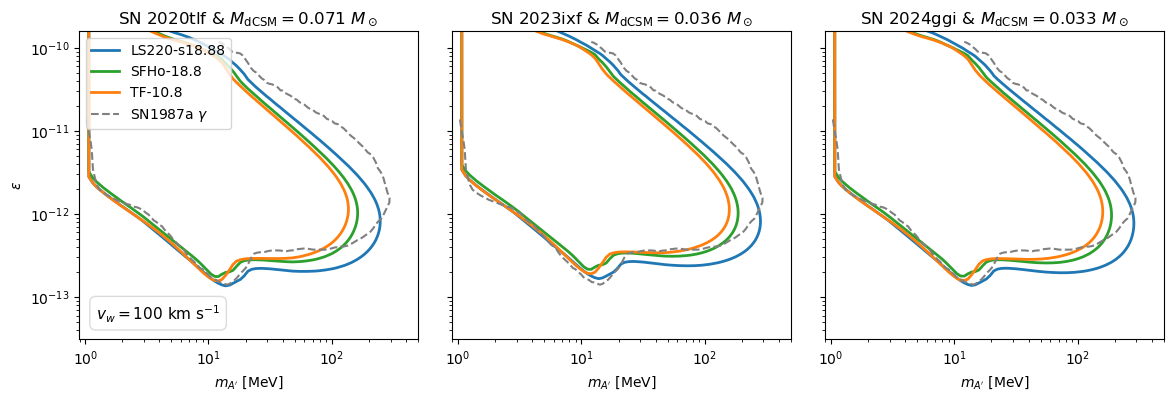

In [214]:
v_csm = 100 # km/s
Q_th_SN2020tlf = np.log10((v_csm*1e5/light_speed)**2*M_CSMs['SN 2020tlf']/2)
Q_th_SN2023ixf = np.log10((v_csm*1e5/light_speed)**2*M_CSMs['SN 2023ixf']/2)
Q_th_SN2024ggi = np.log10((v_csm*1e5/light_speed)**2*M_CSMs['SN 2024ggi']/2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
fig.subplots_adjust(wspace=0.1)

target_contour_LS220_SN2020tlf =  ax1.contour(mAp_mesh, eps_mesh, log_Q_tot_LS220_SN2020tlf, 'r:', levels=[Q_th_SN2020tlf], linewidths=0)
target_contour_TF_SN2020tlf =  ax1.contour(mAp_mesh, eps_mesh, log_Q_tot_TF_SN2020tlf, 'r:', levels=[Q_th_SN2020tlf], linewidths=0)
target_contour_SFHo_SN2020tlf =  ax1.contour(mAp_mesh, eps_mesh, log_Q_tot_SFHo_SN2020tlf, 'r:', levels=[Q_th_SN2020tlf], linewidths=0)

for collection in target_contour_LS220_SN2020tlf.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        ax1.plot(vertices[:, 0], vertices[:, 1],color='C0', linewidth=2, label='LS220-s18.88')

for collection in target_contour_SFHo_SN2020tlf.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        ax1.plot(vertices[:, 0], vertices[:, 1],color='C2', linewidth=2, label='SFHo-18.8')

for collection in target_contour_TF_SN2020tlf.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        ax1.plot(vertices[:, 0], vertices[:, 1],color='C1', linewidth=2, label='TF-10.8')

ax1.plot(sn1987a_gamma_data.T[0],sn1987a_gamma_data.T[1],'--',color='gray',label=r'SN1987a $\gamma$')
ax1.set_title(fr'SN 2020tlf & $M_{{\rm dCSM}}={M_CSMs['SN 2020tlf']/M_sun_erg:.3f}~M_\odot$')
legend = ax1.legend(loc='upper left')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$m_{A^\prime}$ [MeV]')
ax1.set_ylabel(r'$\epsilon$')
ax1.set_xlim(0.89,)
ax1.set_ylim(3.1e-14,)


# 獲取圖例的外框樣式
legend_bbox = legend.get_frame()
legend_facecolor = legend_bbox.get_facecolor()  # 背景顏色
legend_edgecolor = legend_bbox.get_edgecolor()  # 邊框顏色
legend_boxstyle = legend_bbox.get_boxstyle()    # 邊框樣式


# 在右上角添加文字，外框樣式與圖例一致
# 在右上角添加文字，並設置外框和透明背景
ax1.text(
    0.05,0.05, fr'$v_w={v_csm:d}$ km s$^{{-1}}$', 
    transform=ax1.transAxes,
    fontsize=11,
    verticalalignment='bottom', horizontalalignment='left',
    bbox=dict(
        facecolor=legend_facecolor,  # 背景顏色
        alpha=0.7,          # 透明度
        edgecolor=legend_edgecolor,  # 外框顏色
        boxstyle= 'round,pad=0.4'
    )
)



target_contour_LS220_SN2023ixf =  ax2.contour(mAp_mesh, eps_mesh, log_Q_tot_LS220_SN2023ixf, 'r:', levels=[Q_th_SN2023ixf], linewidths=0)
target_contour_TF_SN2023ixf =  ax2.contour(mAp_mesh, eps_mesh, log_Q_tot_TF_SN2023ixf, 'r:', levels=[Q_th_SN2023ixf], linewidths=0)
target_contour_SFHo_SN2023ixf =  ax2.contour(mAp_mesh, eps_mesh, log_Q_tot_SFHo_SN2023ixf, 'r:', levels=[Q_th_SN2023ixf], linewidths=0)

for collection in target_contour_LS220_SN2023ixf.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        ax2.plot(vertices[:, 0], vertices[:, 1],color='C0', linewidth=2, label='LS220-s18.88')

for collection in target_contour_SFHo_SN2023ixf.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        ax2.plot(vertices[:, 0], vertices[:, 1],color='C2', linewidth=2, label='SFHo-18.8')

for collection in target_contour_TF_SN2023ixf.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        ax2.plot(vertices[:, 0], vertices[:, 1],color='C1', linewidth=2, label='TF-10.8')

ax2.plot(sn1987a_gamma_data.T[0],sn1987a_gamma_data.T[1],'--',color='gray',label=r'SN1987a $\gamma$')
ax2.set_title(fr'SN 2023ixf & $M_{{\rm dCSM}}={M_CSMs['SN 2023ixf']/M_sun_erg:.3f}~M_\odot$')
#ax2.legend(loc='lower left')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'$m_{A^\prime}$ [MeV]')
#ax2.set_ylabel(r'$\epsilon$')
ax2.set_xlim(0.89,)
ax2.set_ylim(3.1e-14,)


target_contour_LS220_SN2024ggi =  ax3.contour(mAp_mesh, eps_mesh, log_Q_tot_LS220_SN2024ggi, 'r:', levels=[Q_th_SN2024ggi], linewidths=0)
target_contour_TF_SN2024ggi =  ax3.contour(mAp_mesh, eps_mesh, log_Q_tot_TF_SN2024ggi, 'r:', levels=[Q_th_SN2024ggi], linewidths=0)
target_contour_SFHo_SN2024ggi =  ax3.contour(mAp_mesh, eps_mesh, log_Q_tot_SFHo_SN2024ggi, 'r:', levels=[Q_th_SN2024ggi], linewidths=0)

for collection in target_contour_LS220_SN2024ggi.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        ax3.plot(vertices[:, 0], vertices[:, 1],color='C0', linewidth=2, label='LS220-s18.88')

for collection in target_contour_SFHo_SN2024ggi.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        ax3.plot(vertices[:, 0], vertices[:, 1],color='C2', linewidth=2, label='SFHo-18.8')

for collection in target_contour_TF_SN2024ggi.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        ax3.plot(vertices[:, 0], vertices[:, 1],color='C1', linewidth=2, label='TF-10.8')

ax3.plot(sn1987a_gamma_data.T[0],sn1987a_gamma_data.T[1],'--',color='gray',label=r'SN1987a $\gamma$')
ax3.set_title(fr'SN 2024ggi & $M_{{\rm dCSM}}={M_CSMs['SN 2024ggi']/M_sun_erg:.3f}~M_\odot$')
#ax2.legend(loc='lower left')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel(r'$m_{A^\prime}$ [MeV]')
#ax2.set_ylabel(r'$\epsilon$')
ax3.set_xlim(0.89,)
ax3.set_ylim(3.1e-14,)

#plt.savefig(f'CSM_constraint_vw{v_csm:d}.pdf',bbox_inches='tight')

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_23139/2417768068.py:8: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in target_contour_LS220_SN2023ixf.collections:
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_23139/2417768068.py:13: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in target_contour_SFHo_SN2023ixf.collections:
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_23139/2417768068.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in target_contour_TF_SN2023ixf.collections:


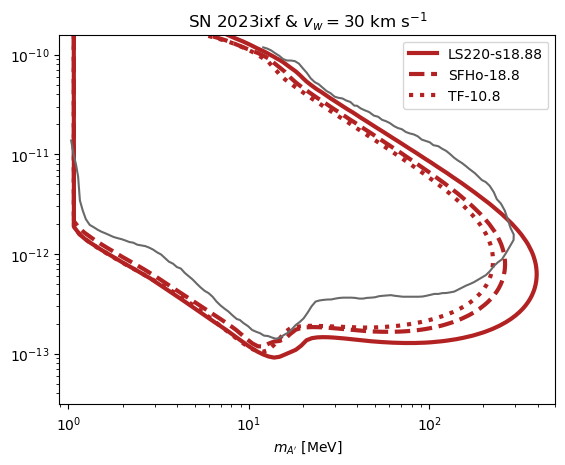

In [676]:
v_csm = 30 # km/s
Q_th_SN2023ixf = np.log10((v_csm*1e5/light_speed)**2*M_CSMs['SN 2023ixf']/2)

target_contour_LS220_SN2023ixf =  plt.contour(mAp_mesh, eps_mesh, log_Q_tot_LS220_SN2023ixf, 'r:', levels=[Q_th_SN2023ixf], linewidths=0)
target_contour_TF_SN2023ixf =  plt.contour(mAp_mesh, eps_mesh, log_Q_tot_TF_SN2023ixf, 'r:', levels=[Q_th_SN2023ixf], linewidths=0)
target_contour_SFHo_SN2023ixf =  plt.contour(mAp_mesh, eps_mesh, log_Q_tot_SFHo_SN2023ixf, 'r:', levels=[Q_th_SN2023ixf], linewidths=0)

for collection in target_contour_LS220_SN2023ixf.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        plt.plot(vertices[:, 0], vertices[:, 1],color='firebrick', linewidth=3, label='LS220-s18.88')

for collection in target_contour_SFHo_SN2023ixf.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        plt.plot(vertices[:, 0], vertices[:, 1],color='firebrick', linestyle='--',linewidth=3, label='SFHo-18.8')

for collection in target_contour_TF_SN2023ixf.collections:
    for path in collection.get_paths():
        vertices = path.vertices  # 取得等值線的點
        plt.plot(vertices[:, 0], vertices[:, 1],color='firebrick', linestyle=':', linewidth=3, label='TF-10.8')

plt.plot(sn1987a_gamma_data.T[0],sn1987a_gamma_data.T[1],color='dimgrey')
plt.title(fr'SN 2023ixf & $v_w={v_csm:d}$ km s$^{{-1}}$')
#ax2.legend(loc='lower left')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m_{A^\prime}$ [MeV]')
#ax2.set_ylabel(r'$\epsilon$')
plt.xlim(0.89,)
plt.ylim(3.1e-14,)

legend = plt.legend(loc='upper right')

# # 獲取圖例的外框樣式
# legend_bbox = legend.get_frame()
# legend_facecolor = legend_bbox.get_facecolor()  # 背景顏色
# legend_edgecolor = legend_bbox.get_edgecolor()  # 邊框顏色
# legend_boxstyle = legend_bbox.get_boxstyle()    # 邊框樣式


# # 在右上角添加文字，外框樣式與圖例一致
# # 在右上角添加文字，並設置外框和透明背景
# plt.text(
#     0.01,0.03, fr'$v_w={v_csm:d}$ km s$^{{-1}}$', 
#     transform=ax1.transAxes,
#     fontsize=11,
#     verticalalignment='bottom', horizontalalignment='left',
#     bbox=dict(
#         facecolor=legend_facecolor,  # 背景顏色
#         alpha=0.7,          # 透明度
#         edgecolor=legend_edgecolor,  # 外框顏色
#         boxstyle= 'round,pad=0.4'
#     )
# )
plt.savefig('DP_constraint.pdf',bbox_inches='tight')

### Enclosed CSM mass and energy deposition at $r$ 

In [382]:
CSM_radii = np.logspace(np.log10(r_mins['SN 2023ixf']),16,50)
enclosed_M_CSM = np.array([4*np.pi*quad(lambda r: r**2 * CSM_density(r,SN_name='SN 2023ixf'),r_mins['SN 2023ixf'],r,
                                epsabs=1.49e-10, epsrel=1.49e-10)[0] / 1.989e33 for r in CSM_radii]) # in terms of solar mass
M_max = max(enclosed_M_CSM)
M_min = min(enclosed_M_CSM)

# The radius equals l_stop at different Ek
requal_Ek50 = get_r_equal_esl(50,target='H',SN_name='SN 2023ixf')
requal_Ek250 = get_r_equal_esl(250,target='H',SN_name='SN 2023ixf')

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_23139/953640815.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  enclosed_M_CSM = np.array([4*np.pi*quad(lambda r: r**2 * CSM_density(r,SN_name='SN 2023ixf'),r_mins['SN 2023ixf'],r,


In [550]:
Q_mAp_3p01_MeV_eps_m12 = np.array([total_energy_deposition(16,r_mins['SN 2023ixf'],r,eps_list = [1e-12],SN_profile='LS220') for r in CSM_radii])
Q_mAp_10p47_MeV_eps_m12 = np.array([total_energy_deposition(34,r_mins['SN 2023ixf'],r,eps_list = [1e-12],SN_profile='LS220') for r in CSM_radii])
Q_mAp_102p32_MeV_eps_m12 = np.array([total_energy_deposition(67,r_mins['SN 2023ixf'],r,eps_list = [1e-12],SN_profile='LS220') for r in CSM_radii])

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_23139/1808155019.py:49: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  energy_dep = quad(lambda r: dQ(eps,r),r_min,r_max)[0]
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_23139/1808155019.py:49: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  energy_dep = quad(lambda r: dQ(eps,r),r_min,r_max)[0]


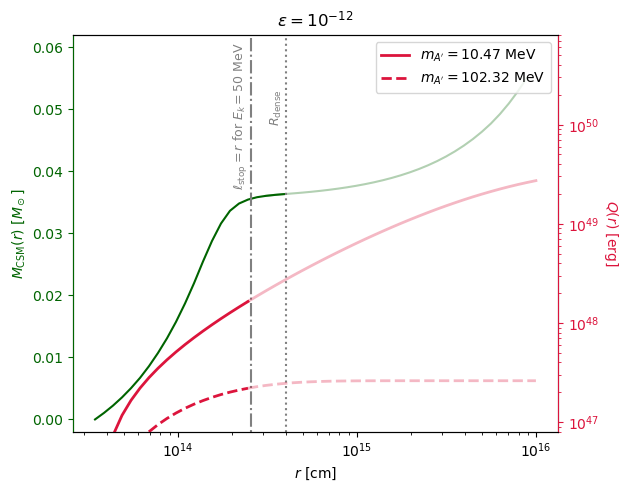

In [602]:
# 2. 建立畫布與第一個座標軸 (ax1)
fig, ax1 = plt.subplots()

mask_left_MCSM = CSM_radii <= 4e14
mask_right_MCSM = CSM_radii >= 3e14
# 繪製左邊 Y 軸的線條
color = 'darkgreen'
ax1.set_xlabel(r'$r$ [cm]')
ax1.set_ylabel(r'$M_{\rm CSM}(r)$ [$M_\odot$]', color=color)
ax1.plot(CSM_radii[mask_left_MCSM],enclosed_M_CSM[mask_left_MCSM],color=color)
ax1.plot(CSM_radii[mask_right_MCSM],enclosed_M_CSM[mask_right_MCSM],color=color,alpha=0.3)
ax1.set_xscale('log')
ax1.tick_params(axis='y', colors=color) # 讓刻度文字也變綠色

ax1.plot([4e14,4e14],[-0.5,M_max+1],':',color='gray')

ax1.plot([requal_Ek50,requal_Ek50],[-0.5,M_max+1],'-.',color='gray')
#ax1.plot([requal_Ek250,requal_Ek250],[-0.5,M_max],'--',color='C2')

ax1.text(2e14,0.038,r'$\ell_{\rm stop}=r$ for $E_k=50$ MeV',fontsize=9,rotation=90,color='gray')
ax1.text(3.22e14,0.048,r'$R_{\rm dense}$',fontsize=9,rotation=90,color='gray')

ax1.set_ylim(-0.002,0.062)
# 3. 建立共用 X 軸的第二個座標軸 (ax2)
ax2 = ax1.twinx() 

# 繪製右邊 Y 軸的線條

mask_left_Q = CSM_radii <= requal_Ek50
mask_right_Q = CSM_radii >= requal_Ek50/1.05

color2 = 'crimson'
ax2.set_ylabel(r'$Q(r)$ [erg]', color=color2, rotation=270, labelpad=15)
ax2.plot(CSM_radii[mask_left_Q],Q_mAp_10p47_MeV_eps_m12[mask_left_Q], color=color2, linewidth=2, label=r'$m_{A^\prime}=10.47$ MeV')
ax2.plot(CSM_radii[mask_right_Q],Q_mAp_10p47_MeV_eps_m12[mask_right_Q], color=color2, linewidth=2,alpha=0.3)

ax2.plot(CSM_radii[mask_left_Q],Q_mAp_102p32_MeV_eps_m12[mask_left_Q], linestyle='--', color=color2, linewidth=2, label=r'$m_{A^\prime}=102.32$ MeV')
ax2.plot(CSM_radii[mask_right_Q],Q_mAp_102p32_MeV_eps_m12[mask_right_Q], linestyle='--', color=color2, linewidth=2,alpha=0.3)
#ax2.plot(CSM_radii,Q_mAp_102p32_MeV, color=color2, linestyle='--', linewidth=2)
ax2.set_yscale('log')
ax2.tick_params(axis='y', which='both', colors=color2) 
ax2.spines['left'].set_color(color)
ax2.spines['right'].set_color(color2)
ax2.set_ylim(8e46,8e50)

#ax2.text(2e15,3.2e49,r'$m_{A^\prime}=10.47$ MeV',fontsize=10,color=color2)
#ax2.text(2e15,3.2e47,r'$m_{A^\prime}=102.32$ MeV',fontsize=10,color=color2)

# 4. 調整佈局並顯示
fig.tight_layout()
plt.legend()
plt.title(r'$\epsilon=10^{-12}$')
plt.savefig('enclosed_eps_1e-12.png',bbox_inches='tight')

In [574]:
Q_mAp_3p01_MeV_eps_m13 = np.array([total_energy_deposition(16,r_mins['SN 2023ixf'],r,eps_list = [2e-13],SN_profile='LS220') for r in CSM_radii])
Q_mAp_10p47_MeV_eps_m13 = np.array([total_energy_deposition(34,r_mins['SN 2023ixf'],r,eps_list = [1.5e-13],SN_profile='LS220') for r in CSM_radii])
Q_mAp_102p32_MeV_eps_m13 = np.array([total_energy_deposition(67,r_mins['SN 2023ixf'],r,eps_list = [1.5e-13],SN_profile='LS220') for r in CSM_radii])

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_23139/1808155019.py:49: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  energy_dep = quad(lambda r: dQ(eps,r),r_min,r_max)[0]
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_23139/1808155019.py:49: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  energy_dep = quad(lambda r: dQ(eps,r),r_min,r_max)[0]


Text(0.5, 1.0, '$\\epsilon=10^{-12}$')

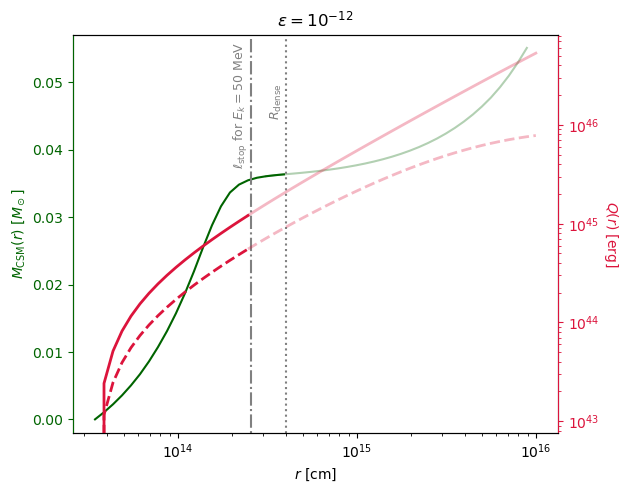

In [572]:
# 2. 建立畫布與第一個座標軸 (ax1)
fig, ax1 = plt.subplots()

mask_left_MCSM = CSM_radii <= 4e14
mask_right_MCSM = CSM_radii >= 3e14
# 繪製左邊 Y 軸的線條
color = 'darkgreen'
ax1.set_xlabel(r'$r$ [cm]')
ax1.set_ylabel(r'$M_{\rm CSM}(r)$ [$M_\odot$]', color=color)
ax1.plot(CSM_radii[mask_left_MCSM],enclosed_M_CSM[mask_left_MCSM],color=color)
ax1.plot(CSM_radii[mask_right_MCSM],enclosed_M_CSM[mask_right_MCSM],color=color,alpha=0.3)
ax1.set_xscale('log')
ax1.tick_params(axis='y', colors=color) # 讓刻度文字也變綠色

ax1.plot([4e14,4e14],[-0.5,M_max+1],':',color='gray')

ax1.plot([requal_Ek50,requal_Ek50],[-0.5,M_max+1],'-.',color='gray')
#ax1.plot([requal_Ek250,requal_Ek250],[-0.5,M_max],'--',color='C2')

ax1.text(2e14,0.038,r'$\ell_{\rm stop}$ for $E_k=50$ MeV',fontsize=9,rotation=90,color='gray')
ax1.text(3.22e14,0.045,r'$R_{\rm dense}$',fontsize=9,rotation=90,color='gray')

ax1.set_ylim(-0.002,0.057)
# 3. 建立共用 X 軸的第二個座標軸 (ax2)
ax2 = ax1.twinx() 

# 繪製右邊 Y 軸的線條

mask_left_Q = CSM_radii <= requal_Ek50
mask_right_Q = CSM_radii >= requal_Ek50/1.05

color2 = 'crimson'
ax2.set_ylabel(r'$Q(r)$ [erg]', color=color2, rotation=270, labelpad=15)
ax2.plot(CSM_radii[mask_left_Q],Q_mAp_10p47_MeV_eps_m13[mask_left_Q], color=color2, linewidth=2)
ax2.plot(CSM_radii[mask_right_Q],Q_mAp_10p47_MeV_eps_m13[mask_right_Q], color=color2, linewidth=2,alpha=0.3)

ax2.plot(CSM_radii[mask_left_Q],Q_mAp_102p32_MeV_eps_m13[mask_left_Q], linestyle='--', color=color2, linewidth=2)
ax2.plot(CSM_radii[mask_right_Q],Q_mAp_102p32_MeV_eps_m13[mask_right_Q], linestyle='--', color=color2, linewidth=2,alpha=0.3)
#ax2.plot(CSM_radii,Q_mAp_102p32_MeV, color=color2, linestyle='--', linewidth=2)
ax2.set_yscale('log')
ax2.tick_params(axis='y', which='both', colors=color2) 
ax2.spines['left'].set_color(color)
ax2.spines['right'].set_color(color2)
#ax2.set_ylim(8e46,8e50)

#ax2.text(2e15,3.2e49,r'$m_{A^\prime}=102.32$ MeV',fontsize=10,color=color2)
#ax2.text(2e15,3.2e47,r'$m_{A^\prime}=10.47$ MeV',fontsize=10,color=color2)

# 4. 調整佈局並顯示
fig.tight_layout() 
plt.title(r'$\epsilon=10^{-12}$')
#plt.savefig('enclosed_eps_1e-11.pdf',bbox_inches='tight')

Text(0, 0.5, '$M_{\\rm CSM}(r)$ [$M_\\odot$]')

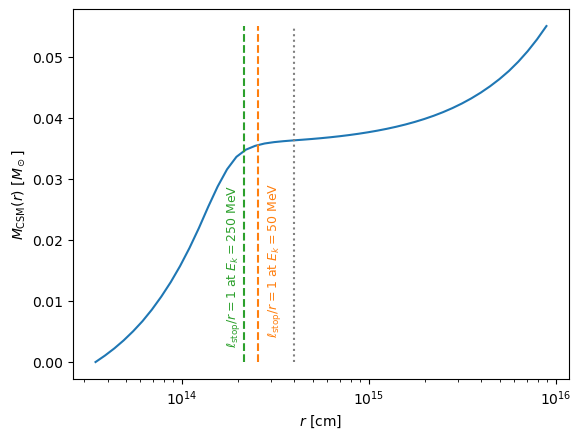

In [192]:
plt.plot(CSM_radii,enclosed_M_CSM)
plt.plot([4e14,4e14],[M_min,M_max],':',color='gray')

plt.plot([requal_Ek50,requal_Ek50],[M_min,M_max],'--',color='C1')
plt.plot([requal_Ek250,requal_Ek250],[M_min,M_max],'--',color='C2')

plt.text(2.8e14,0.005,r'$\ell_{\rm stop}/r=1$ at $E_k=50$ MeV',fontsize=9,rotation=90,color='C1')
plt.text(1.69e14,0.0035,r'$\ell_{\rm stop}/r=1$ at $E_k=250$ MeV',fontsize=9,rotation=90,color='C2')
plt.xscale('log')
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$M_{\rm CSM}(r)$ [$M_\odot$]')

Text(0, 0.5, '$M_{\\rm CSM}(r)$ [$M_\\odot$]')

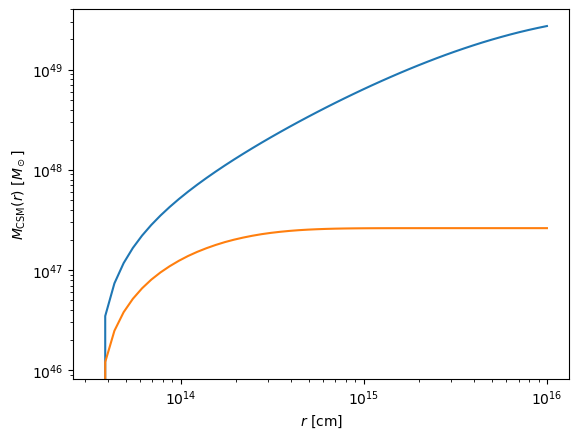

In [254]:
#plt.plot(CSM_radii,Q_mAp_3p01_MeV)
plt.plot(CSM_radii,Q_mAp_10p47_MeV)
plt.plot(CSM_radii,Q_mAp_102p32_MeV)
#plt.plot([4e14,4e14],[M_min,M_max],':',color='gray')

# plt.plot([requal_Ek50,requal_Ek50],[M_min,M_max],'--',color='C1')
# plt.plot([requal_Ek250,requal_Ek250],[M_min,M_max],'--',color='C2')

#plt.text(2.8e14,0.005,r'$\ell_{\rm stop}/r=1$ at $E_k=50$ MeV',fontsize=9,rotation=90,color='C1')
#plt.text(1.69e14,0.0035,r'$\ell_{\rm stop}/r=1$ at $E_k=250$ MeV',fontsize=9,rotation=90,color='C2')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$M_{\rm CSM}(r)$ [$M_\odot$]')

In [682]:
energy_deposition(34,1e14,1e-12,SN_profile='LS220')

7.934150000000052e+33

In [704]:
def CSM_dM(r,SN_name='SN 2023ixf'):
    rho = CSM_density(r,SN_name) # g/cm^3
    return 4 * np.pi * r**2 * rho * 8.9876e20 # erg / cm

In [742]:
v_layer_m13 = [np.sqrt(2 * energy_deposition(67,r,1e-13,SN_profile='LS220') / CSM_dM(r,SN_name='SN 2023ixf'))*300000 for r in CSM_radii]
v_layer_m11 = [np.sqrt(2 * energy_deposition(67,r,1e-11,SN_profile='LS220') / CSM_dM(r,SN_name='SN 2023ixf'))*300000 for r in CSM_radii]

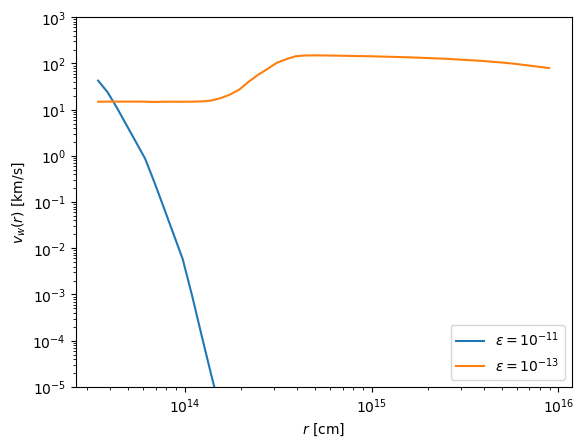

In [754]:
plt.plot(CSM_radii,v_layer_m11,label=r'$\epsilon=10^{-11}$')
plt.plot(CSM_radii,v_layer_m13,label=r'$\epsilon=10^{-13}$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower right')
plt.ylim(1e-5,1e3)
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$v_w(r)$ [km/s]')
plt.savefig('vw_per_layer.png',bbox_inches='tight')

In [ ]:
)

In [716]:
np.array(v_layer)*300000

array([ 1816.17199293,  1825.17533643,  1823.38363877,  1819.70336889,
        1820.0259913 ,  1812.64443418,  1787.26137569,  1803.70337182,
        1799.43105366,  1795.23087944,  1799.53452175,  1816.20840448,
        1887.91985617,  2119.24956569,  2520.95612816,  3217.16844461,
        4745.69857447,  6672.48720159,  8918.76776045, 12113.06187744,
       14416.6658258 , 16640.99463244, 17246.23053023, 17246.56697078,
       17059.54508386, 16858.44867161, 16587.11374995, 16309.61636558,
       16057.27653824, 15808.84087315, 15480.02422612, 15148.99408856,
       14825.04281278, 14508.01902198, 14098.21636546, 13691.68348239,
       13296.87328683, 12913.44774611, 12427.10666152, 11952.17594539,
       11495.39580858, 11056.07258458, 10506.89763465,  9980.06043225,
        9442.84387323,  8817.58138359,  8239.89615189,  7681.27918184,
        7170.68697755,            nan])

In [698]:
CSM_dM(1e14,SN_name='SN 2023ixf') * 8.9876e20 

4.435581537226015e+38

In [248]:
mAp_axis[16]

3.019951684379908